# Exploratory Data Analysis

Explore general aspects about the data from an historical perspective and also looking at the most recent batch

In [1]:
from database_settings import spark_utilities

In [2]:
from pyspark.sql.functions import substring, to_date, col, lpad
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Get the data into a spark dataframe
df = spark_utilities.get_spark_df('peru_exports')

## Historical Data (all batches published)

In [5]:
# Get attributes
print('Number of attributes: ' + str(len(df.columns)))
# Show all possible keys
df.printSchema()

Number of attributes: 12


Row(0='3926909030', 1='ESCAFANDRAS Y MASCARAS DE PROTECCION', 2='15', 3='18', 4='0', 5='0', 6='220', 7='3560', 8='19010101', 9='19971231', LOAD_DATE='20230404', _id=Row(oid='642c1cc9deba07716a98487c'))

In [5]:
# Verify batches
df2 = df.groupBy("BATCH_WEEK")\
    .count()\
    .withColumn("date_str", substring("BATCH_WEEK", 3, 7)) \
    .withColumn("date", to_date("date_str", "ddMMyy")) \
    .orderBy("date")\
    .select(['date', 'count'])\
    .toPandas()

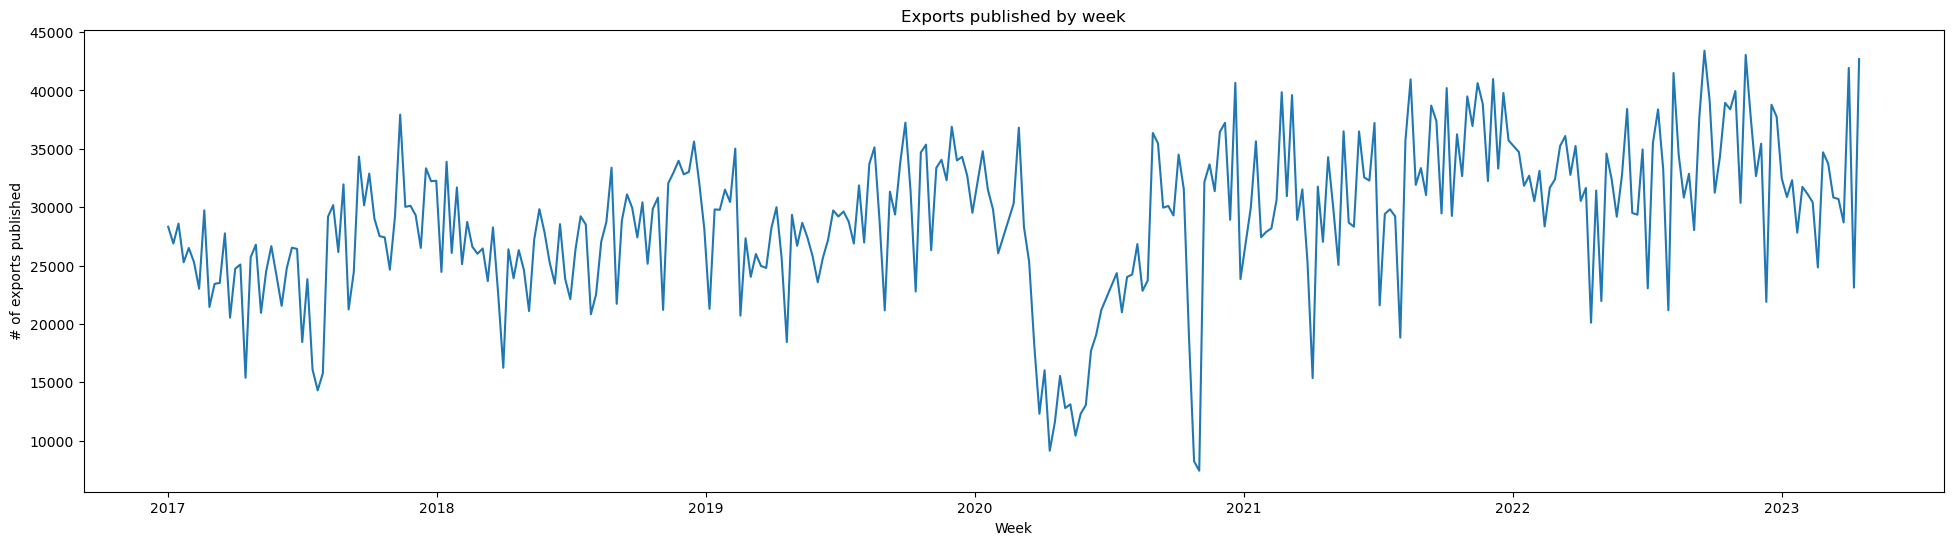

In [6]:
plt.figure(figsize=(24, 6))
plt.plot(df2["date"], df2["count"])
plt.xlabel("Week")
plt.ylabel("# of exports published")
plt.title("Exports published by week")
plt.show()

In [7]:
# Get all possible headings in the data
hs = df.select('PART_NANDI')\
    .distinct()\
    .withColumn("HS", lpad(col("PART_NANDI").cast("string"), 10, "0")) \
    .select('HS')\
    .toPandas()

In [8]:
print('The total number of headings in the data is: '+str(len(hs)))

The total number of headings in the data is: 6477


In [9]:
# Headings to work with:
# 07XXXXXXXX: Hortalizas, plantas, raíces y tubérculos alimenticios
# 08XXXXXXXX: Frutas y frutos comestibles; cortezas de agrios (cítricos), melones o sandías.

hs_to_work = ['07', '08']
hs[hs['HS'].str.startswith(tuple(hs_to_work))].sort_values(by='HS', ascending= True)

,HS
1600,0701100000
5243,0701900000
1602,0702000000
3147,0703100000
149,0703201000
...,...
6177,0813300000
3541,0813400000
5814,0813500000
211,0814001000


## Last batch published

In [10]:
# Last batch
last_batch_week = df.select("BATCH_WEEK")\
    .distinct() \
    .withColumn("date_str", substring("BATCH_WEEK", 3, 7)) \
    .withColumn("date", to_date("date_str", "ddMMyy")) \
    .orderBy("date", ascending=False)\
    .limit(1)\
    .select('BATCH_WEEK')
# Get week code
last_batch_week = last_batch_week.head()[0]
# Get the dataframe
df_last = df.filter(df.BATCH_WEEK == last_batch_week)

In [11]:
# Get count of new registers
print('Number of registers: ' + str(df_last.count()))
# Get attributes
print('Number of attributes: ' + str(len(df_last.columns)))
# Visualize the attributes
df_last.printSchema()

Number of registers: 42693
Number of attributes: 47
root
 |-- BATCH_WEEK: string (nullable = true)
 |-- CADU: string (nullable = true)
 |-- CAGE: string (nullable = true)
 |-- CALM: string (nullable = true)
 |-- CEMPTRA: string (nullable = true)
 |-- CENTFIN: string (nullable = true)
 |-- CEST: string (nullable = true)
 |-- CPAIDES: string (nullable = true)
 |-- CPUEDES: string (nullable = true)
 |-- CUNITRA: string (nullable = true)
 |-- CVIATRA: string (nullable = true)
 |-- DCOM: string (nullable = true)
 |-- DDIRCON: double (nullable = true)
 |-- DDIRPRO: string (nullable = true)
 |-- DK: string (nullable = true)
 |-- DK2: string (nullable = true)
 |-- DMAT: string (nullable = true)
 |-- DMER2: string (nullable = true)
 |-- DMER3: string (nullable = true)
 |-- DMER4: string (nullable = true)
 |-- DMER5: string (nullable = true)
 |-- DNOMBRE: string (nullable = true)
 |-- DNOMCON: double (nullable = true)
 |-- DNOMPRO: string (nullable = true)
 |-- FANO: string (nullable = true)
 |-

In [12]:
# Aggregate exports by day
df_last_agg = df_last.groupBy("FEMB")\
    .count()\
    .withColumn("date", to_date("FEMB", "yyyyMMdd")) \
    .orderBy("date")\
    .select(['date', 'count'])

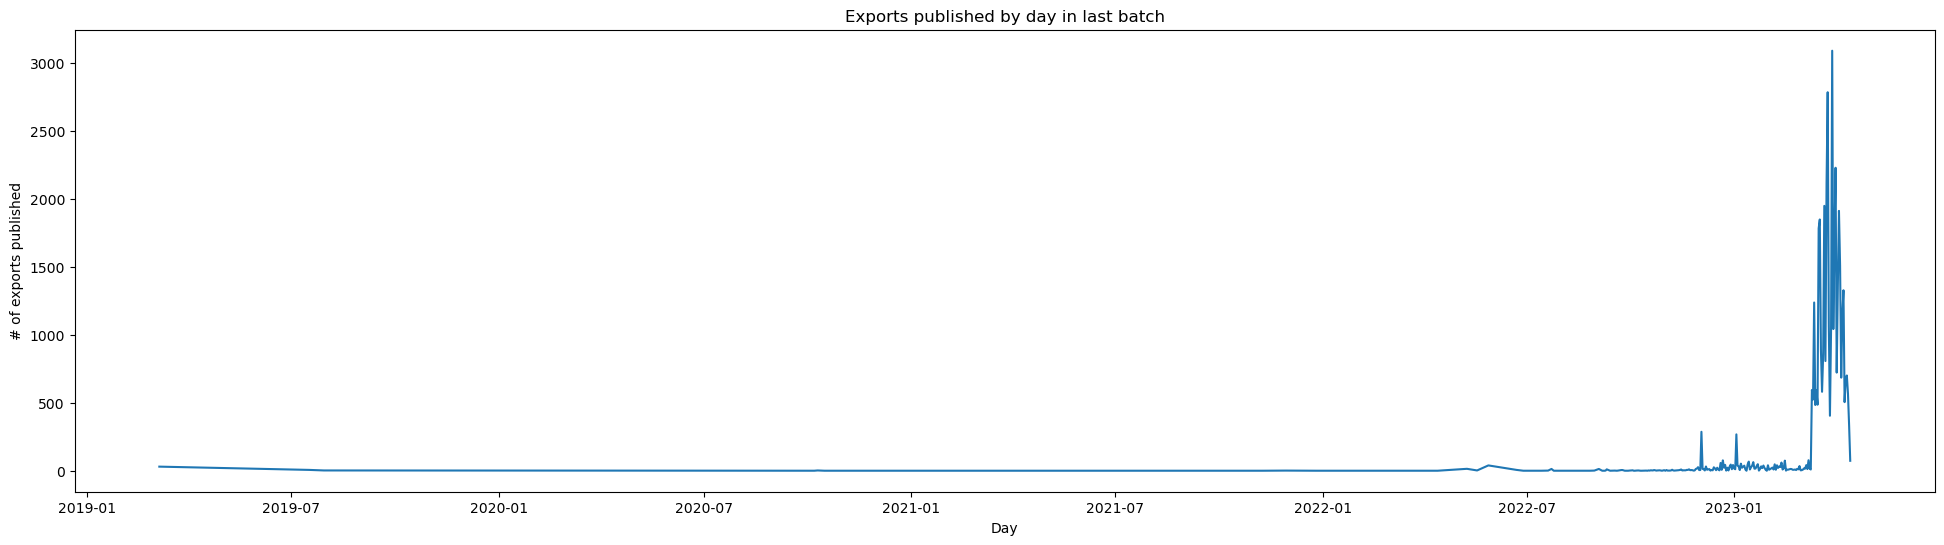

In [13]:
# Plot exports by day in batch
plt.figure(figsize=(24, 6))
plt.plot(df_last_agg.toPandas()["date"], df_last_agg.toPandas()["count"])
plt.xlabel("Day")
plt.ylabel("# of exports published")
plt.title("Exports published by day in last batch")
plt.show()

In [14]:
# Get starting and end dates of the batch's week
week_start_date = datetime.strptime(last_batch_week[0:2]+last_batch_week[4:8], '%d%m%y').date()
week_end_date = datetime.strptime(last_batch_week[2:8], '%d%m%y').date()

In [15]:
# Make a comparison between regular and outdated registrations inside the batch (consider a regular registration one whose shipment date 'FEMB' falls inside the batch's week range)
df_last_reg_out = df_last\
    .withColumn("regular", ((to_date(col('FEMB'), 'yyyyMMdd') >= week_start_date) & (to_date(col('FEMB'), 'yyyyMMdd') <= week_end_date)))\
    .select(['regular'])\
    .toPandas()

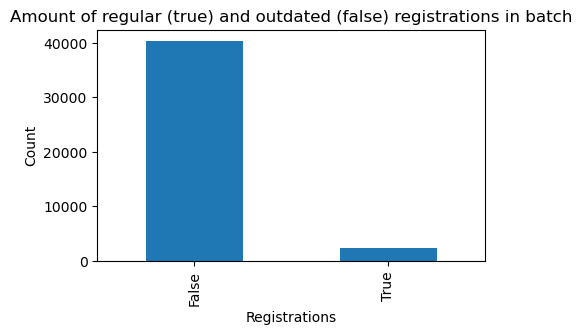

In [16]:
plt.figure(figsize=(5, 3))
df_last_reg_out['regular'].value_counts().plot(kind='bar')
plt.xlabel('Registrations')
plt.ylabel('Count')
plt.title('Amount of regular (true) and outdated (false) registrations in batch')
plt.show()